# Expressibility and engtangling capability

In [1]:
import warnings
import json
import os
import sys
import glob
import numpy
import pickle
import random
import collections

os.environ["OMP_NUM_THREADS"] = "8"
import pennylane as qml

import matplotlib.pyplot as plt

from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
from utils import transform_into_pennylane_circuits, read_diagrams, get_symbols

this_folder = os.path.abspath(os.getcwd())
nshot = 1000

In [2]:
num_of_bins = 75
bins_list = [i/(num_of_bins) for i in range(num_of_bins + 1)]
bins_x = [bins_list[1]+bins_list[i] for i in range(num_of_bins - 1)]

def P_harr(l, u, N):
    return (1-l)**(N-1)-(1-u)**(N-1)

#Harr histogram
P_harr_hist = [P_harr(bins_list[i], bins_list[i+1], 2) for i in range(num_of_bins)]

In [3]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//"\
            + workload + "//" + workload_size + "//circuits//"\
            + str(classification) + "//" + str(layers) + "_layer//"\
           + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count)\
            + "_n_wire_count//"

In [4]:
training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [5]:
training_circuits = read_diagrams(training_circuits_paths)
#validation_circuits = read_diagrams(validation_circuits_paths)
#test_circuits = read_diagrams(test_circuits_paths)

In [6]:
n_qubits = 10
dev = qml.device("lightning.qubit", wires=n_qubits, shots=nshot)

qml_training_circuits, train_symbols = transform_into_pennylane_circuits(training_circuits, n_qubits, dev)
#qml_test_circuits, test_symbols = transform_into_pennylane_circuits(test_circuits, n_qubits, dev)
#qml_validation_circuits, val_symbols = transform_into_pennylane_circuits(validation_circuits, n_qubits, dev)
qml_circuits = qml_training_circuits #+ qml_test_circuits + qml_validation_circuits

## Expressibility

In [7]:
def post_select_circuit_samples(circuit_samples, n_qubits, post_selection):
    selected_samples = []
    post_select_array = np.array([0]*(n_qubits - post_selection))
    for circuit_sample in circuit_samples:
        if np.array_equal(circuit_sample[post_selection - 1 :-1], post_select_array):
            res = circuit_sample[0:post_selection]
            if res[0] == 1:
                selected_samples.append(0)
            else:
                selected_samples.append(1)
    return selected_samples

In [8]:
fidelity=[]
for i, c in enumerate(qml_circuits):
    if i == 0:
        #print("Progress:", i/len(qml_circuits))
        circuit = qml_circuits[c]["qml_circuit"]
        #n_qubits = qml_circuits[c]["n_qubits"]
        symbols = train_symbols

        for x in range(1000):
            params = [2*np.pi*random.uniform(0, 1) for i in range(len(symbols))]
            result = circuit(params)

            #print(result)
            post_selected_result = post_select_circuit_samples(result, n_qubits, 1)
            res = collections.Counter(post_selected_result)

            if 0 in res:
                ratio = res[0]/nshot
            else:
                ratio = 0

            fidelity.append(ratio)
        break

In [9]:
print(len(fidelity))

1000


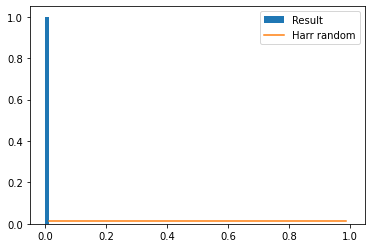

In [10]:
weights = numpy.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Result', range=[0, 1])
plt.plot(bins_x, P_harr_hist[:-1], label='Harr random')
plt.legend(loc='upper right')
plt.show()

In [11]:
from scipy.special import kl_div
P_I_hist = numpy.histogram(fidelity, bins = bins_list, weights = weights, range=[0, 1])[0]
kl_pq = kl_div(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 4.317 nats


In [12]:
with open('results//fidelity_execution_time_1_1_3_1_main.pickle', 'wb') as handle:
    pickle.dump(fidelity, handle, protocol=pickle.HIGHEST_PROTOCOL)